In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

SEED = 1337
random.seed(SEED)

INFO 03-14 01:40:15 __init__.py:190] Automatically detected platform cuda.


In [2]:
df = pd.read_csv("../../data/data_raw/blogs.csv")
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [3]:
df.drop(["id", "gender", "age", "topic", "sign", "date"], axis=1, inplace=True)
df["text"] = df["text"].str.strip()

In [4]:
df.isna().sum()

text    0
dtype: int64

In [5]:
df["length"] = df["text"].str.len()

In [6]:
print(len(df[df["length"] < 50]))
df = df[df["length"] >= 50]

45809


In [7]:
len(df)

635475

In [8]:
df.duplicated(subset="text").sum()

np.int64(58690)

In [9]:
df.drop_duplicates(subset="text", inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
len(df)

576785

In [11]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [12]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for rewritting blogs. Based on provided blog generate a similar one. MAKE SURE TO REPLAY ONLY WITH THE SIMILAR BLOG."},
                {"role": "user", "content": "Blog: \n {blog} \n"},
                {"role": "assistant", "content": "Similar blog: \n"}]

In [13]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(blog=blog)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for blog in df["text"].values
]

In [14]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [15]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

 46%|████▌     | 2073/4506 [03:09<04:25,  9.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (145329 > 131072). Running this sequence through the model will result in indexing errors
4507it [07:26, 10.10it/s]                          


In [16]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
len(too_large)

54

In [17]:
df.drop(["length"], axis=1, inplace=True)
df.drop(too_large, inplace=True)
df.to_csv("../../data/data_human/blogs.csv", index=False)

In [18]:
df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

In [19]:
import numpy as np
import matplotlib.ticker as ticker

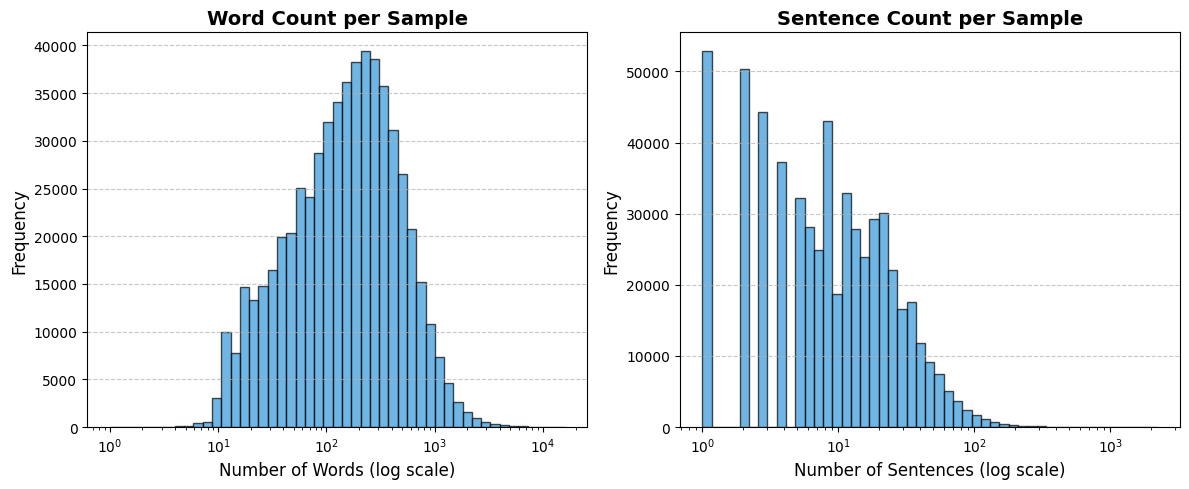

In [20]:
word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=word_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words (log scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=sentence_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
prompts = [prompts[i] for i in range(len(prompts)) if i not in too_large]

In [9]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=40_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=40_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=40_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=40_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=40_000, seed=SEED),  # Highly Creative
]

In [10]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/blogs/blogs_"

In [11]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-14 23:36:01 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-14 23:36:15 config.py:542] This model supports multiple tasks: {'reward', 'score', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 02-14 23:36:15 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-14 23:36:28 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-14 23:36:31 worker.py:267] Memory profiling takes 2.38 seconds
INFO 02-14 23:36:31 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-14 23:36:31 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-14 23:36:31 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-14 23:36:31 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-14 23:37:08 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s]

INFO 02-14 23:37:40 model_runner.py:1562] Graph capturing finished in 32 secs, took 0.12 GiB
INFO 02-14 23:37:40 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 72.62 seconds



  0%|          | 0/85159 [00:00<?, ?it/s]

INFO 02-14 23:37:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/85159 [00:45<543:29:47, 22.98s/it]


In [12]:
df = pd.read_csv("../../data/data_ai/blogs/blogs_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",**Upload Process Update: Our Team Leader is Wo...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",**Team Member Profiles: A Look into the Talent...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",**How to Build a Nuclear Power Plant: A Step-b...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",**Testing: The Ultimate Guide to Ensuring the ...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...",**Discover the Melody of Korea: 24-Hour K-Pop ...,1.2,0.7,20
